# Simulation: single ion Rabi with motional heating

In [41]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
from tqdm.notebook import tqdm
import torch
import time

In [2]:
# Check current version of vessl
!vessl --version

vessl, version 0.1.58


In [3]:
import vessl
project_name = f"simul"
vessl.configure(project_name=project_name)

Username: kmlee258
Email: anfry15rudals@snu.ac.kr
Default organization: snu-eng
Default project: simul


## 1. Parameter definitions

### A. User-defined parameters

In [4]:
n_tot = 50               # total number of number state basis to represent the motional state: starts from zero
n_mean_init = 0         # initial mean number of the motional state
spin_down_init = 1      # initial population of spin down

f_Rabi = 50*10**3       # internal state Rabi frequency: units in Hz
lamda = 1/f_Rabi
f_secular = 1.6*10**6   # secular frequency: units in Hz
f_detuning = 0          # detuning: units in Hz
LD_param = 0.1          # Lamb-Dicke parameter: dimensionless
drift_phase = 0

heating_rate = 3000       # heating rate: units in phonons/sec
T_b = 300               # equilibrium temperature of the phonon heat bath: units in Kelvin

t_tot = 1000*1e-6            # total time to simulate: units in sec
dt = 200e-9               # simulation time step: units in sec
t_scale = (10**6)*dt    # plot time scale: units in us

In [5]:
print('Rabi period: {} us'.format(lamda * 1e6))

Rabi period: 20.0 us


In [13]:
if torch.cuda.is_available():
    print('Use ' + torch.cuda.get_device_name())
    dev = 'cuda'
else:
    print('No GPU device is available')
    dev = 'cpu'

Use NVIDIA A100-SXM4-40GB


### B. Dependent parameters

In [14]:
# returns the mean number of the bath with respect to the motional energy
def return_bath_mean_n():
    hbar = 6.62607015*10**(-34)
    k_B = 1.380649*10**(-23)
    mean_n = 1/(np.exp(hbar*(2*np.pi*f_secular)/(k_B*T_b)) - 1)

    return mean_n

bath_mean_n = return_bath_mean_n()
print('bath mean number: ', round(bath_mean_n))

# returns the coupling efficiency to the bath 
def return_gamma():
    gamma = heating_rate/bath_mean_n

    return gamma

Gamma = return_gamma()
print('Gamma: ', round(Gamma, 6))

# returns the motional decay rate
def return_motional_decay_rate(n):
    decay_rate = Gamma*((2*bath_mean_n + 1)*n + bath_mean_n)/2
    return decay_rate

bath mean number:  621797
Gamma:  0.004825


In [15]:
def get_laguerre(m, n):
    if m == n:
        laguerre_factor = np.exp(-(LD_param**2)/2)*special.genlaguerre(n, 0)(LD_param**2)
    elif m > n:
        n_diff = m- n
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(n)/special.factorial(m))**(1/2)
        laguerre_factor = laguerre_coeff*((1j*LD_param)**n_diff)*special.genlaguerre(n, n_diff)(LD_param**2)
    elif m < n:
        n_diff = n - m
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(m)/special.factorial(n))**(1/2)
        laguerre_factor = laguerre_coeff*((1j*LD_param)**n_diff)*special.genlaguerre(m, n_diff)(LD_param**2)
    return laguerre_factor

def get_laguerre_prime(m, n):
    if m == n:
        laguerre_factor = np.exp(-(LD_param**2)/2)*special.genlaguerre(n, 0)(LD_param**2)
    elif m > n:
        n_diff = m- n
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(n)/special.factorial(m))**(1/2)
        laguerre_factor = laguerre_coeff*((-1j*LD_param)**n_diff)*special.genlaguerre(n, n_diff)(LD_param**2)
    elif m < n:
        n_diff = n - m
        laguerre_coeff = np.exp(-(LD_param**2)/2)*(special.factorial(m)/special.factorial(n))**(1/2)
        laguerre_factor = laguerre_coeff*((-1j*LD_param)**n_diff)*special.genlaguerre(m, n_diff)(LD_param**2)
    return laguerre_factor

## 2. Simulation

## Matrix version

In [28]:
def get_evolved_K(K_mat, K_d_mat, K_evolve_mat):
    K_mat_dt = torch.einsum('ijkl,ijkl->ijkl', K_evolve_mat, K_mat)
    K_d_mat_dt = torch.einsum('ijkl,ijkl->ijkl', K_evolve_mat, K_d_mat)
    return K_mat_dt, K_d_mat_dt

In [29]:
def get_summed_term(rho_prev, K_mat, K_d_mat, J_mat, J_d_mat): 
    K_term1 = torch.einsum('mria,rnaj->mnij', K_mat, rho_prev)
    K_term2 = torch.einsum('mria,rnaj->mnij', rho_prev, K_d_mat)
    
    rho_n_plus = torch.zeros_like(rho_prev, dtype=torch.complex128)
    rho_n_minus = torch.zeros_like(rho_prev, dtype=torch.complex128)

    rho_n_plus[:-1,:-1] = rho_prev.clone()[1:,1:]
    rho_n_minus[1:,1:] = rho_prev.clone()[:-1,:-1]
    
    J_term1 = torch.einsum('ij,ijkh->ijkh', J_mat, rho_n_plus)
    J_term2 = torch.einsum('ij,ijkh->ijkh', J_d_mat, rho_n_minus)
        
    return K_term1 + K_term2 + J_term1 + J_term2

In [45]:
def simulation(transition = 'blue'):
    
    # initialize the density matrix elements
    sim_init_array = np.zeros((n_tot,n_tot,2,2), dtype=complex)
    sim_empty_array = np.zeros((n_tot,n_tot,2,2), dtype=complex)

    sim_spin = np.array([[complex(spin_down_init), complex(0)], [complex(0), complex(1 - spin_down_init)]])
    sim_spin.reshape(2, 2)
    sim_empty = np.array([[complex(0), complex(0)], [complex(0), complex(0)]])
    sim_empty.reshape(2, 2)

    for n in range(n_tot):
        prob_n = (1/(n_mean_init + 1))*(n_mean_init/(n_mean_init + 1))**n
        sim_init_array[n,n] = prob_n * sim_spin

    sim_init_array /= sim_init_array.sum()

    sim_init_array = torch.from_numpy(sim_init_array).to(dev)
    sim_spin = torch.from_numpy(sim_spin).to(dev)
    sim_empty = torch.from_numpy(sim_empty).to(dev)


    # Initial J, Jd matrix --> Constant since there's no time dependencies
    J_matrix = np.zeros((n_tot,n_tot), dtype=complex)
    J_d_matrix = np.zeros((n_tot,n_tot), dtype=complex)
    for m in range(n_tot):
        for n in range(n_tot):        
            J_matrix[m,n] = Gamma*(bath_mean_n + 1)*(((m + 1)*(n + 1))**(1/2))
            J_d_matrix[m,n] = Gamma*bath_mean_n*((m*n)**(1/2))          

    J_matrix = torch.from_numpy(J_matrix).to(dev)
    J_d_matrix = torch.from_numpy(J_d_matrix).to(dev)

    # Initial K, Kd matrix
    K_matrix = np.zeros_like(sim_empty_array, dtype=complex)
    K_d_matrix = np.zeros_like(sim_empty_array, dtype=complex)
    for m in range(n_tot):
        for n in range(n_tot):
            f_mn = get_laguerre(m,n)
            f_mn_prime = get_laguerre_prime(m,n)
            K_matrix[m,n] = -(1j/2)*np.array([[0, f_mn * 2*np.pi * f_Rabi], [f_mn_prime * 2*np.pi * f_Rabi, 0]], dtype=complex)    
            K_d_matrix[m,n] = (1j/2)*np.array([[0, f_mn * 2*np.pi * f_Rabi], [f_mn_prime * 2*np.pi * f_Rabi, 0]], dtype=complex) 
            if m == n:
                K_matrix[m,n] -= return_motional_decay_rate(n)*np.eye(2, dtype=complex)
                K_d_matrix[m,n] -= return_motional_decay_rate(n)*np.eye(2, dtype=complex)

    K_matrix = torch.from_numpy(K_matrix).to(dev)
    K_d_matrix = torch.from_numpy(K_d_matrix).to(dev)
   

    if transition == 'blue':
        f_detuning = f_secular
    elif transition == 'red':
        f_detuning = -f_secular
    else:
        f_detuning = 0

    # Evolve K matrix for dt / 2
    K_evolve_matrix = np.ones_like(K_matrix.cpu(), dtype=complex)
    for m in range(n_tot):
        for n in range(n_tot):
            K_evolve_matrix[m,n] = np.array([[1, np.exp(1j*2*np.pi*((m-n)*f_secular + f_detuning)*dt/2)], 
                                             [np.exp(1j*2*np.pi*((m-n)*f_secular - f_detuning)*dt/2), 1]])
    K_evolve_matrix = torch.from_numpy(K_evolve_matrix).to(dev)

    
    sim_timeline = {'time_step' : list(), 'prob_up' : list(), 'rho_hist': []}

    traced = sim_init_array.sum(axis=(0,1))
    prob_up = traced[1][1].real
    sim_timeline['time_step'].append(0)      # plot units in us
    sim_timeline['prob_up'].append(prob_up.cpu().detach().numpy())

    # update density matrix elements
    sim_prev = cp.deepcopy(sim_init_array)
    sim_next = cp.deepcopy(sim_empty_array)
    sim_timeline['rho_hist'].append(sim_prev.clone().cpu().detach().numpy())

    time = 0
    for it in tqdm(range(round(t_tot/dt))): 
        
        summed = get_summed_term(sim_prev, K_matrix, K_d_matrix, J_matrix, J_d_matrix)
        k1 = summed * dt

        K_matrix, K_d_matrix = get_evolved_K(K_matrix, K_d_matrix, K_evolve_matrix)
        
        summed = get_summed_term(sim_prev + k1/2, K_matrix, K_d_matrix, J_matrix, J_d_matrix)
        k2 = summed * dt
        
        summed = get_summed_term(sim_prev + k2/2, K_matrix, K_d_matrix, J_matrix, J_d_matrix)
        k3 = summed * dt

        K_matrix, K_d_matrix = get_evolved_K(K_matrix, K_d_matrix, K_evolve_matrix)
        
        summed = get_summed_term(sim_prev + k3, K_matrix, K_d_matrix, J_matrix, J_d_matrix)
        k4 = summed * dt

        sim_next = sim_prev + (k1 + 2*k2 + 2*k3 + k4)/6

        traced = sim_next.sum(axis=(0,1))
        prob_up = traced[1][1].real

        sim_timeline['time_step'].append((it+1)*t_scale)      # plot units in us
        sim_timeline['prob_up'].append(prob_up.cpu().detach().numpy())
        sim_timeline['rho_hist'].append(sim_next.clone().cpu().detach().numpy())

        sim_prev = cp.deepcopy(sim_next)
        sim_next = cp.deepcopy(sim_empty_array)
        
    vessl.log(
        sim_timeline   
    )

    sim_final_array = cp.deepcopy(sim_prev)
    
    return sim_timeline

In [50]:
vessl.init()

Initializing a new experiment...
Connected to experiment #9.
For more info: https://vessl.ai/snu-eng/simul/experiments/9


In [51]:
start_t = time.time()
result = simulation('carrier')
elapsed_t = time.time() - start_t
print(elapsed_t)

  0%|          | 0/5000 [00:00<?, ?it/s]

9.936933517456055


In [52]:
# Finish experiment
vessl.finish()

Experiment 9 completed.


In [53]:
for i in range(len(result['rho_hist'])):
    result['rho_hist'][2].sum(axis=(0,1))

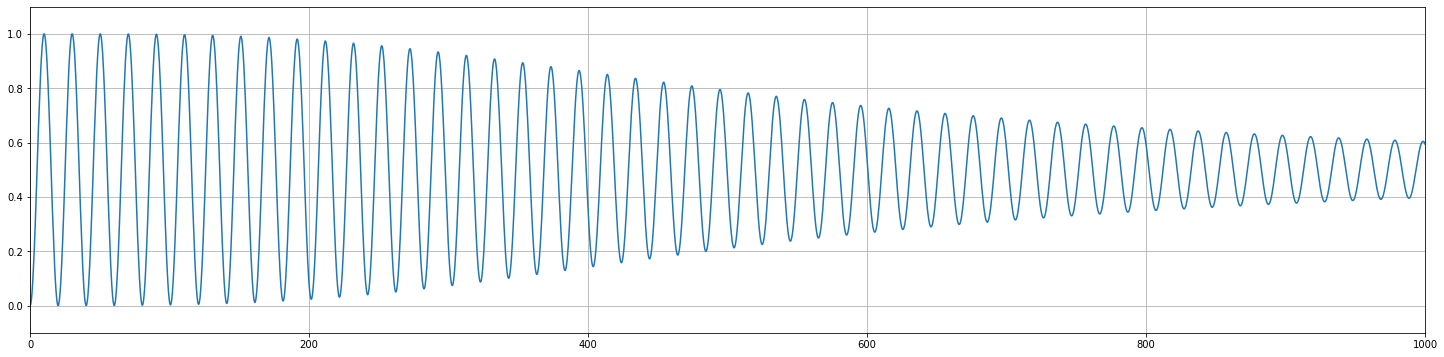

In [54]:
plt.rcParams['figure.figsize'] = (25,6)
plt.grid()
plt.xlim(0, result['time_step'][-1])
plt.ylim(-0.1, 1.1)
plt.plot(result['time_step'][:], result['prob_up'][:])

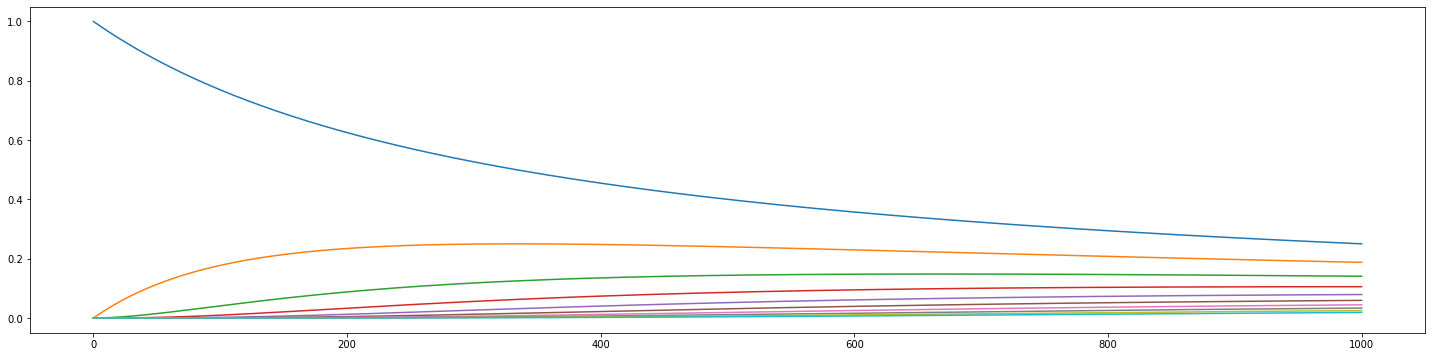

In [55]:
for n in range(10):
    plt.plot(result['time_step'], 
             [np.diag(result['rho_hist'][i][n,n]).sum().real for i in range(len(result['rho_hist']))])